# 네이버 영화리뷰 감성분석 도전하기
## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/AIFFEL/Exploration/E4_sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/AIFFEL/Exploration/E4_sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성
----------------------------
__`data_loader` 안에서는 다음을 수행해야 한다.__
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

## 3) 모델구성을 위한 데이터 분석 및 가공
-----------------------
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [4]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  54
전체 문장의 97.20946661956906%가 maxlen 설정값 이내에 포함됩니다. 


RNN을 사용할 것이기 때문에 pre로 정했다.

In [5]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 54)


## 4) 모델구성 및 validation set 구성
-----------------------
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### LSTM 모델

In [6]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_LSTM.add(keras.layers.Dense(128, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 250,881
Trainable params: 250,881
Non-trainable params: 0
_________________________________________________________________


### CNN 모델

In [7]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16

model_Conv1D = keras.Sequential()
model_Conv1D.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_Conv1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D.add(keras.layers.MaxPooling1D(5))
model_Conv1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D.add(keras.layers.GlobalMaxPooling1D())
model_Conv1D.add(keras.layers.Dense(128, activation='relu'))
model_Conv1D.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_Conv1D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## GlobalMaxPooling1D() 하나만 사용한 모델
__이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있다.__

In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16

model_GMP1D = keras.Sequential()
model_GMP1D.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP1D.add(keras.layers.GlobalMaxPooling1D())
model_GMP1D.add(keras.layers.Dense(128, activation='relu'))
model_GMP1D.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP1D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 162,305
Trainable params: 162,305
Non-trainable params: 0
_________________________________________________________________


validation set 구성하기

In [9]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 136182건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 54)
(136182,)


## 5) 모델 훈련 개시
----------------------------------
### LSTM 모델 훈련 시작!

In [10]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_LSTM = model_LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model_LSTM.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/5
266/266 [==============================] - 3s 11ms/step - loss: 0.4260 - accuracy: 0.7968 - val_loss: 0.3495 - val_accuracy: 0.8491
Epoch 2/5
266/266 [==============================] - 3s 10ms/step - loss: 0.3320 - accuracy: 0.8588 - val_loss: 0.3392 - val_accuracy: 0.8530
Epoch 3/5
266/266 [==============================] - 3s 10ms/step - loss: 0.3136 - accuracy: 0.8685 - val_loss: 0.3380 - val_accuracy: 0.8504
Epoch 4/5
266/266 [==============================] - 3s 10ms/step - loss: 0.2979 - accuracy: 0.8756 - val_loss: 0.3311 - val_accuracy: 0.8571
Epoch 5/5
266/266 [==============================] - 3s 10ms/step - loss: 0.2763 - accuracy: 0.8836 - val_loss: 0.3309 - val_accuracy: 0.8605
1537/1537 - 3s - loss: 0.3420 - accuracy: 0.8539
[0.34197762608528137, 0.8539170622825623]


### CNN 모델 학습 시작!

In [11]:
model_Conv1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_Conv1D = model_Conv1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model_Conv1D.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/5
266/266 [==============================] - 7s 25ms/step - loss: 0.5187 - accuracy: 0.7237 - val_loss: 0.4300 - val_accuracy: 0.7961
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3950 - accuracy: 0.8133 - val_loss: 0.4199 - val_accuracy: 0.7965
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3574 - accuracy: 0.8342 - val_loss: 0.4217 - val_accuracy: 0.7930
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3194 - accuracy: 0.8542 - val_loss: 0.4334 - val_accuracy: 0.7995
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2794 - accuracy: 0.8748 - val_loss: 0.4677 - val_accuracy: 0.7878
1537/1537 - 3s - loss: 0.4781 - accuracy: 0.7859
[0.478115439414978, 0.7858901023864746]


### GlobalMaxPooling1D() 모델 학습 시작!

In [12]:
model_GMP1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_GMP1D = model_GMP1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model_GMP1D.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/5
266/266 [==============================] - 1s 4ms/step - loss: 0.4949 - accuracy: 0.7724 - val_loss: 0.3622 - val_accuracy: 0.8358
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3377 - accuracy: 0.8540 - val_loss: 0.3445 - val_accuracy: 0.8489
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3030 - accuracy: 0.8722 - val_loss: 0.3436 - val_accuracy: 0.8518
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2804 - accuracy: 0.8833 - val_loss: 0.3525 - val_accuracy: 0.8480
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2632 - accuracy: 0.8915 - val_loss: 0.3629 - val_accuracy: 0.8462
1537/1537 - 1s - loss: 0.3760 - accuracy: 0.8420
[0.3759588599205017, 0.8420367240905762]


## 6) Loss, Accuracy 그래프 시각화
---------------------------------------
### LSTM 모델의 Loss, Accuracy 그래프

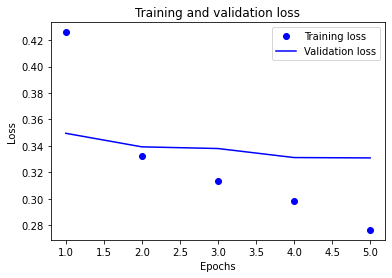

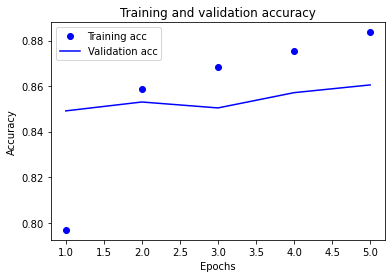

In [13]:
import matplotlib.pyplot as plt

history_dict_LSTM = history_LSTM.history

acc = history_dict_LSTM['accuracy']
val_acc = history_dict_LSTM['val_accuracy']
loss = history_dict_LSTM['loss']
val_loss = history_dict_LSTM['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN 모델의 Loss, Accuracy 그래프

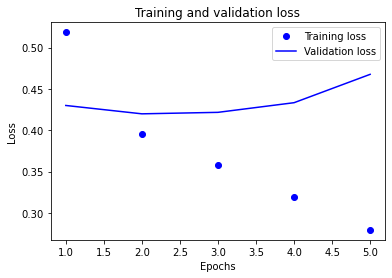

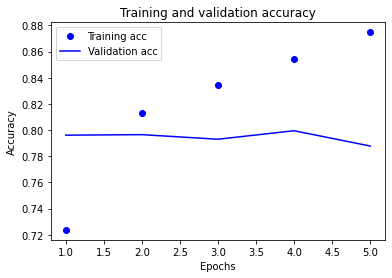

In [14]:
import matplotlib.pyplot as plt

history_dict_Conv1D = history_Conv1D.history

acc = history_dict_Conv1D['accuracy']
val_acc = history_dict_Conv1D['val_accuracy']
loss = history_dict_Conv1D['loss']
val_loss = history_dict_Conv1D['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D() 모델의 Loss, Accuracy 그래프

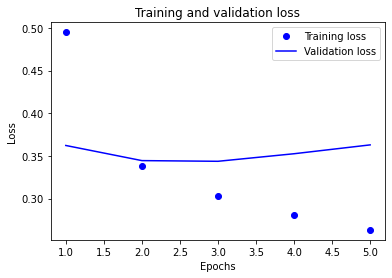

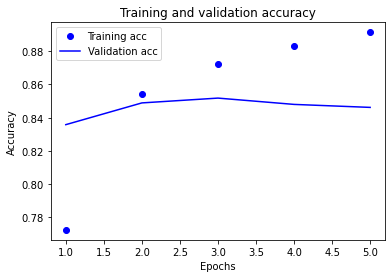

In [15]:
import matplotlib.pyplot as plt

history_dict_GMP1D = history_GMP1D.history

acc = history_dict_GMP1D['accuracy']
val_acc = history_dict_GMP1D['val_accuracy']
loss = history_dict_GMP1D['loss']
val_loss = history_dict_GMP1D['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석
-----------------------------
라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법으로 단어의 특성을 저차원 벡터값으로 표현할 수 있는 `워드 임베딩(word embedding)` 기법이 있다. 그 기법을 사용할 것이다.<br>
아래 코드는 워드벡터를 다루는데 유용한 gensim 패키지를 설치하는 코드이다.


```
$ pip install gensim
```


In [16]:
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


### LSTM 모델로 학습한 Embedding 파라미터를 파일에 써서 저장

In [17]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_LSTM = os.getenv('HOME')+'/AIFFEL/Exploration/E4_sentiment_classification/word2vec_LSTM.txt'
f = open(word2vec_file_path_LSTM, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_LSTM = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_LSTM[i, :])))))
f.close()

### CNN 모델로 학습한 Embedding 파라미터를 파일에 써서 저장

In [18]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_Conv1D = os.getenv('HOME')+'/AIFFEL/Exploration/E4_sentiment_classification/word2vec_Conv1D.txt'
f = open(word2vec_file_path_Conv1D, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_Conv1D = model_Conv1D.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_Conv1D[i, :])))))
f.close()

### GlobalMaxPooling1D() 모델로 학습한 Embedding 파라미터를 파일에 써서 저장

In [19]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_GMP1D = os.getenv('HOME')+'/AIFFEL/Exploration/E4_sentiment_classification/word2vec_GMP1D.txt'
f = open(word2vec_file_path_GMP1D, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_GMP1D = model_GMP1D.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_GMP1D[i, :])))))
f.close()

`gensim`에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다.

### LSTM 모델 학습한 걸로 유사 단어 찾기.

In [20]:
from gensim.models import KeyedVectors
word2vec_path_LSTM = os.getenv('HOME')+'/AIFFEL/Exploration/E4_sentiment_classification/word2vec_LSTM.txt'
word2vec_LSTM = KeyedVectors.load_word2vec_format(word2vec_path_LSTM, limit=1000000)
vector_LSTM = word2vec_LSTM['재밌']
vector_LSTM 

array([ 0.0809165 , -0.13020796,  0.03837604, -0.14119516, -0.12750031,
       -0.11584544, -0.11540292,  0.1470474 , -0.06796686, -0.07261936,
       -0.08900445,  0.11269029, -0.12264521,  0.11897823, -0.02269963,
       -0.11709216], dtype=float32)

In [21]:
word2vec_LSTM.similar_by_word("재밌")

[('겸손', 0.9764194488525391),
 ('괜춘', 0.974841296672821),
 ('일리', 0.9720107316970825),
 ('방학', 0.9701666831970215),
 ('하모니', 0.964205801486969),
 ('노동자', 0.9621592164039612),
 ('묻히', 0.9617784023284912),
 ('풍성', 0.961401641368866),
 ('흠잡', 0.9602104425430298),
 ('뒤돌아보', 0.9600777626037598)]

`재밌`과 유사한 단어들을 찾아야 하는데 생뚱맞은 단어들이 많이 나왔다. 좀 더 정확하고 좋은 `워드 임베딩` 모델이 필요할 듯 하다. <br> __그래서 필요한게 한국어 Word2Vec!!!__

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
---------------------------------
한국어 `Word2Vec`은 다음 경로에서 구할 수 있다.

[https://github.com/Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

In [22]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

kor_word2vec_path = os.getenv('HOME')+'/AIFFEL/Exploration/E4_sentiment_classification/ko/ko.bin'
kor_word2vec = gensim.models.Word2Vec.load(kor_word2vec_path)
kor_vector = kor_word2vec['재밌']
kor_vector 

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([-5.70638835e-01, -1.89795382e-02,  4.18168336e-01, -6.65361881e-01,
       -5.78920126e-01, -2.65187681e-01,  1.67045116e-01, -4.47417080e-01,
       -2.26184875e-01,  2.07026631e-01, -2.82414615e-01, -2.04017460e-01,
        3.99801224e-01,  8.95581722e-01, -4.10150111e-01, -5.30177832e-01,
       -1.00408584e-01, -7.79470429e-02,  6.55694246e-01, -6.14580512e-01,
       -3.47350031e-01,  2.93210238e-01,  3.37972194e-01, -1.82576463e-01,
       -1.41739815e-01, -1.29240826e-01,  9.38577205e-02,  1.57903805e-01,
        2.13528946e-01, -2.51577020e-01,  3.94223571e-01,  1.12120651e-01,
       -2.87773311e-01,  2.46506810e-01,  4.22204509e-02,  9.81939062e-02,
        2.20483780e-01,  2.81774312e-01, -4.36879396e-01, -1.82436377e-01,
        2.22101465e-01, -7.39264041e-02,  5.66517971e-02, -2.31536046e-01,
        2.88119078e-01,  6.94155395e-02,  4.00188655e-01,  3.44122946e-01,
       -5.23211434e-02, -2.06091240e-01, -2.24862620e-01,  3.06395590e-01,
        2.28373617e-01,  

In [23]:
kor_word2vec.similar_by_word("주식")

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('지분', 0.659886360168457),
 ('증권', 0.6218825578689575),
 ('사채', 0.617996335029602),
 ('자본금', 0.6030240058898926),
 ('현물', 0.5963727235794067),
 ('주주', 0.5927848815917969),
 ('코스닥', 0.5803253650665283),
 ('모회사', 0.579328179359436),
 ('상장', 0.5687190890312195),
 ('어음', 0.5640698075294495)]

### kor_word2vec를 불러와서 좀 더 정확한 LSTM 모델 사용하기.

In [24]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [25]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_upgrade_LSTM = keras.Sequential()
model_upgrade_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_upgrade_LSTM.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_upgrade_LSTM.add(keras.layers.Dense(128, activation='relu'))
model_upgrade_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_upgrade_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,185,089
Trainable params: 2,185,089
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_upgrade_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_upgrade_LSTM = model_upgrade_LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 9s 33ms/step - loss: 0.4378 - accuracy: 0.7904 - val_loss: 0.3468 - val_accuracy: 0.8465
Epoch 2/5
266/266 [==============================] - 8s 32ms/step - loss: 0.3174 - accuracy: 0.8630 - val_loss: 0.3230 - val_accuracy: 0.8598
Epoch 3/5
266/266 [==============================] - 8s 32ms/step - loss: 0.2758 - accuracy: 0.8845 - val_loss: 0.3133 - val_accuracy: 0.8666
Epoch 4/5
266/266 [==============================] - 9s 32ms/step - loss: 0.2467 - accuracy: 0.8988 - val_loss: 0.3204 - val_accuracy: 0.8656
Epoch 5/5
266/266 [==============================] - 9s 32ms/step - loss: 0.2211 - accuracy: 0.9101 - val_loss: 0.3341 - val_accuracy: 0.8667


In [27]:
# 테스트셋을 통한 모델 평가
results = model_upgrade_LSTM.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3387 - accuracy: 0.8642
[0.33869051933288574, 0.8642106056213379]


accuracy는 85에서 86으로 늘어나고, loss는 0.35에서 0.32로 떨어진 것을 볼 수 있다.

### kor_word2vec를 불러와서 좀 더 정확한 CNN 모델 사용하기.

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [29]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_upgrade_Conv1D = keras.Sequential()
model_upgrade_Conv1D.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_upgrade_Conv1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_upgrade_Conv1D.add(keras.layers.MaxPooling1D(5))
model_upgrade_Conv1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_upgrade_Conv1D.add(keras.layers.GlobalMaxPooling1D())
model_upgrade_Conv1D.add(keras.layers.Dense(128, activation='relu'))
model_upgrade_Conv1D.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_upgrade_Conv1D.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [30]:
model_upgrade_Conv1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_upgrade_Conv1D = model_upgrade_Conv1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 10s 39ms/step - loss: 0.5808 - accuracy: 0.6776 - val_loss: 0.5075 - val_accuracy: 0.7481
Epoch 2/5
266/266 [==============================] - 7s 25ms/step - loss: 0.4573 - accuracy: 0.7769 - val_loss: 0.4529 - val_accuracy: 0.7808
Epoch 3/5
266/266 [==============================] - 7s 25ms/step - loss: 0.4049 - accuracy: 0.8082 - val_loss: 0.4380 - val_accuracy: 0.7830
Epoch 4/5
266/266 [==============================] - 7s 25ms/step - loss: 0.3733 - accuracy: 0.8246 - val_loss: 0.4394 - val_accuracy: 0.7890
Epoch 5/5
266/266 [==============================] - 7s 26ms/step - loss: 0.3487 - accuracy: 0.8383 - val_loss: 0.4448 - val_accuracy: 0.7827


In [31]:
# 테스트셋을 통한 모델 평가
results = model_upgrade_Conv1D.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4474 - accuracy: 0.7873
[0.4473750591278076, 0.7872734069824219]


In [ ]:
흠..... 정확도가 더 떨어지네... 왜그러지??

### kor_word2vec를 불러와서 좀 더 정확한 GlobalMaxPooling1D()모델 사용하기.

In [32]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [33]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_upgrade_GMP1D = keras.Sequential()
model_upgrade_GMP1D.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_GMP1D.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_upgrade_GMP1D.add(keras.layers.GlobalMaxPooling1D())
model_upgrade_GMP1D.add(keras.layers.Dense(128, activation='relu'))
model_upgrade_GMP1D.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_upgrade_GMP1D.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 2,025,857
Trainable params: 2,025,857
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_upgrade_GMP1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_upgrade_GMP1D = model_upgrade_GMP1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 7s 26ms/step - loss: 0.6316 - accuracy: 0.6460 - val_loss: 0.5558 - val_accuracy: 0.7182
Epoch 2/5
266/266 [==============================] - 7s 25ms/step - loss: 0.5196 - accuracy: 0.7414 - val_loss: 0.4991 - val_accuracy: 0.7572
Epoch 3/5
266/266 [==============================] - 7s 25ms/step - loss: 0.4683 - accuracy: 0.7767 - val_loss: 0.4582 - val_accuracy: 0.7854
Epoch 4/5
266/266 [==============================] - 7s 25ms/step - loss: 0.4310 - accuracy: 0.7999 - val_loss: 0.4353 - val_accuracy: 0.7984
Epoch 5/5
266/266 [==============================] - 7s 25ms/step - loss: 0.4072 - accuracy: 0.8145 - val_loss: 0.4221 - val_accuracy: 0.8038


In [35]:
# 테스트셋을 통한 모델 평가
results = model_upgrade_GMP1D.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4314 - accuracy: 0.8005
[0.4313809871673584, 0.8004556894302368]


흠....... 요것도 마찬가지고......

## 루브릭 평가
__* 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.__

LSTM, CNN, GlobalMaxPooling1D() 세가지 모델로 Text Classification task를 성공적으로 구현하였다.<br> 
세가지 모델 전부 dense를 128로 높였고, 기본 epoch이 20이었는데 epoch 4쯤에서 오버피팅이 나는 것을 보고, epoch을 5로 줄였다.<br>
추가적으로 LSTM 모델의 경우에는, LSTM state 벡터의 차원수를 8에서 128로 증가시켰다.



__* 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.__

gensim을 활용하여 LSTM, CNN, GlobalMaxPooling1D() 세가지 모델로 학습된 임베딩 레이어를 분석한 결과, 네이버 영화 리뷰 내의 한정된 단어로 학습을 진행했기에 similar 단어 찾을때, 연관 없는 단어들이 많이 나왔다.

__* 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.__

한국어 Word2Vec을 활용하여 업그레이드 된(?) LSTM 모델을 만들었다. accuracy는 높이고 loss를 줄였다.

## 질문
한국어 Word2Vec을 활용하여 만든 LSTM모델은 왜 더 성능이 향상되고 나머지 두 모델들은 왜 성능 저하가 되었는지 궁금하다...

## 느낀점
여러가지 하이퍼 파라미터들을 조정하면서 accuracy를 높이는 것이 번거로운 일이라는 것을 깨달았다.ㅋㅋㅋ 뭔가 땅을 파서 뭔가를 찾는 느낌??
점점 더 프로젝트가 커지고 어려워지고 있는데 그걸 버텨내고 있는 내가 성장하고 있다는 게 느껴진다. 이번 프로젝트로 오랜만에 밤도 새보고 힘들었지만 동시에 배움의 즐거움을 느낄 수 있어 너무 좋았다.ㅎㅎㅎ   